$\left\{\begin{array}{l}d x=-y d t+\sigma_1 d W_t^1 \\ d y=\frac{1}{\varepsilon}\left(y-\frac{1}{3} y^3+x\right) d t+\frac{\sigma_2}{\sqrt{\varepsilon}} d W_t^2\end{array}\right.$

$\left\{\begin{array}{l}d x=-2y d t+\sigma_1 d W_t^1, \\ d y=\frac{1}{2\varepsilon}\left(2y-\frac{8}{3} y^3 +x \right) d t+\frac{\sigma_2}{2\sqrt{\varepsilon}} d W_t^2,\end{array}\right.$

# Preamble

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from datetime import datetime
import sdeint
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.spatial.distance import cdist
import random
from scipy.signal import butter, filtfilt
from matplotlib import rcParams
import os

In [2]:
# parameters
data_length = 2000
wait_time = 500

# Plot Parameters
# fontsize = 20
ticksize = 20
nbinsx_attractor = 6
nbinsy_attractor = 8
nbinsx_time_series = 9
nbinsy_time_series = 5
box_linewidth = 1.5
tick_width = 1
tick_length= 7
attractor_color = 'darkviolet'
transient_color = 'silver'


# setting number of training and testing points
train_test_depth = data_length - wait_time # length of perturbation for training and testing
train_pts = 1000
test_pts = 500

# setting number of controlledling
controlled_wait1 = 200 # number of points to wait until controlled begins
t1 = controlled_wait1+wait_time
transient_end1 = t1 + 10 # number of points to wait until controlled system is stabilized
controlled_wait2 = 390 # number of points to wait until controlled begins
t2 = transient_end1+controlled_wait2#500
transient_end2 = t2 + 10 # number of points to wait until controlled system is stabilized
controlled_wait3 = 490 # number of points to wait until controlled begins
t3 = transient_end2+controlled_wait3#1000
transient_end3 = t3 + 10 # number of points to wait until controlled system is stabilized

# iteration 
time_array = np.arange(data_length)
dt = 0.01
t = dt * time_array
t_show = dt * np.arange(train_test_depth)

In [3]:
# # Silence all deprecation warnings
# import warnings
# warnings.filterwarnings("ignore", category=FutureWarning)

# Generate original and desired data

In [4]:
# system parameter

sigma1, sigma2 = 1,  1
epsilon = 0.1

In [5]:
def generate_data_sto(sigma1, sigma2, epsilon, NT, n):
    # 初始条件
    d = 2 #x,y
    xy0 = np.random.uniform(0.1, 0.8, d)  
     
    X = np.zeros((d, NT))
    X[:, 0] = xy0

 
    # 创建噪声项
    N = np.zeros((d, NT))
    np.random.seed(n)
    S = np.sqrt(dt) * np.random.randn(d,NT)
    # 数值迭代生成数据
    for i in range(NT - 1):
        
        # 生成随机扰动
        UUt = S[0, i]
        VVt = S[1, i]

        N[0, i] = sigma1 * UUt  # 为 x 添加噪声
        N[1, i] = (sigma2 / np.sqrt(epsilon)) * VVt  # 为 y 添加噪声
        
        f_x = -X[1, i]
        f_y = (1/epsilon) * (X[1, i] - (1/3) * X[1, i]**3 + X[0, i])


        # 使用欧拉迭代公式更新状态
        X[0, i+1] = X[0, i] + f_x * dt + N[0, i]
        X[1, i+1] = X[1, i] + f_y * dt + N[1, i]


    return X, S, N, xy0





In [6]:
# 调用生成数据函数
original_data_total, sto_origin_total, noise_origin_total, xy0 = generate_data_sto(sigma1, sigma2, epsilon, data_length,20)
original_data = original_data_total[:,wait_time:]

In [7]:
def task_picker(task):
    """
    Create desired signals for use in the controlled algorithm.
    
    Parameters:
        task (int): The original task is chosen with task=1, the two USS task is 
        chosen with task=2, and the random task is chosen with task=3
        
    Returns:
        Y_desired (numpy.ndarray): Contains the desired signal in digital form
    """

    # original task
    if task == 1:
        
        # setting the desired trajectory to zero
        Y_desired = np.zeros(data_length)


    elif task == 2:
    
        # 取训练y的一半
        Y_desired = np.array([1/2*original_data_total[0],1/2*original_data_total[1]])
  
    elif task == 3:
        Y_desired = np.zeros((2,data_length))
        # 取训练y的一半
        Y_desired[:, 0:t2] = np.array([1.3*original_data_total[0],1.3*original_data_total[1]])[:, 0:t2]
        Y_desired[:, t2:t3] = np.array([0.8*original_data_total[0],0.8*original_data_total[1]])[:, t2:t3]
        Y_desired[:, t3:]  = np.array([0.5*original_data_total[0],0.5*original_data_total[1]])[:, t3:]
 
    # random task
    elif task == 4:
        
        # setting the parameters for random uniform noise
        
        # setting maximum value of the random uniform noise
        max_uniform = 1.0 
        
        # make the uniform random noise
        Y_desired = np.random.uniform(-max_uniform, max_uniform, data_length)


    return Y_desired

In [8]:
# select the task (1:original,2:two USS,3:random)
task = 3

# get the desired signal that corresponds to the specified task
Y_desired = task_picker(task)

c:\Users\cheng\.conda\envs\openv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


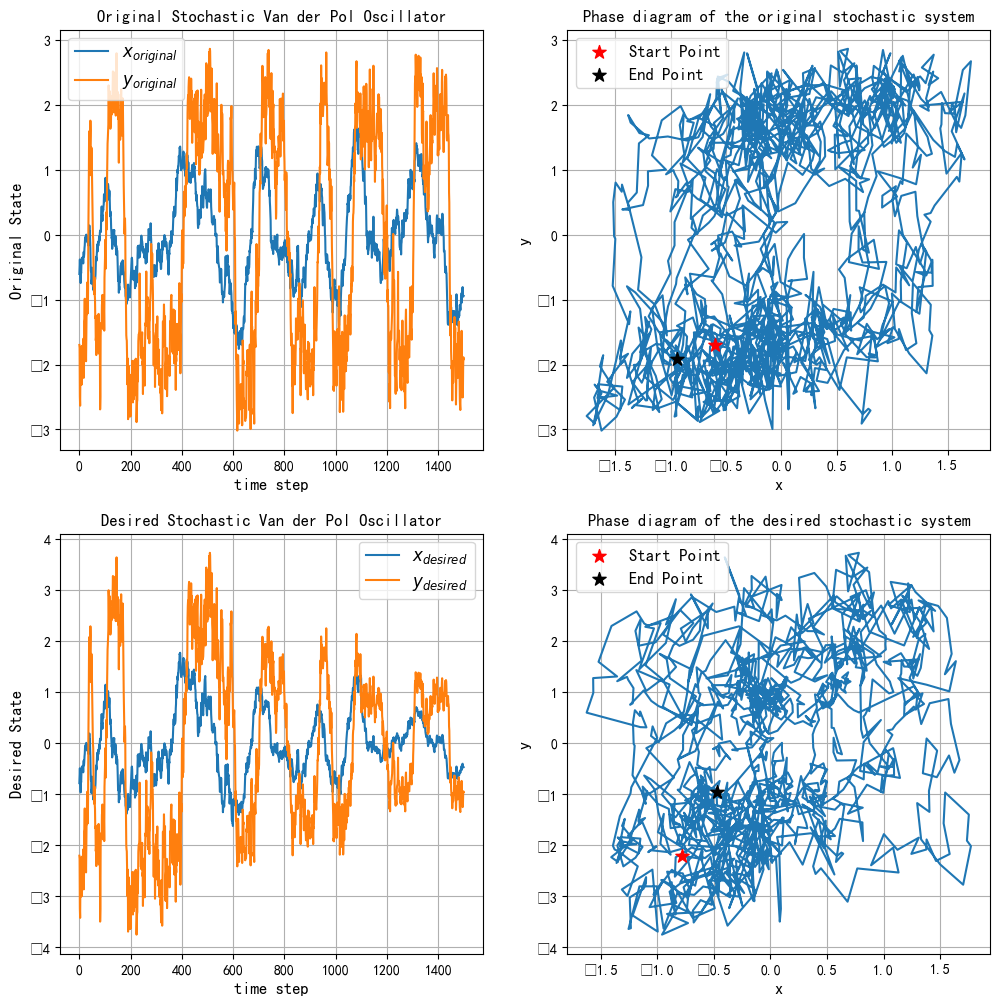

In [9]:
fontsize = 12
# 数据
x, y = original_data[0], original_data[1]
x_des, y_des = Y_desired[0, wait_time:], Y_desired[1, wait_time:]

# 创建画布
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# 1. 原始轨迹随时间变化
ax = axes[0, 0]
ax.plot(x, label=r'$x_{original}$')
ax.plot(y, label=r'$y_{original}$')
ax.set_xlabel('time step', fontsize=fontsize)
ax.set_ylabel('Original State', fontsize=fontsize)
ax.legend(fontsize=fontsize)
ax.set_title('Original Stochastic Van der Pol Oscillator', fontsize=fontsize)
ax.grid(True)

# 2. 原始轨迹相图
ax = axes[0, 1]
ax.plot(x, y)
ax.scatter([x[0]], [y[0]], color='red', marker='*', s=100, label='Start Point', zorder=10)
ax.scatter([x[-1]], [y[-1]], color='black', marker='*', s=100, label='End Point', zorder=10)
ax.set_xlabel('x', fontsize=fontsize)
ax.set_ylabel('y', fontsize=fontsize)
ax.legend(fontsize=fontsize)
ax.set_title('Phase diagram of the original stochastic system', fontsize=fontsize)
ax.grid(True)

# 3. 期望轨迹随时间变化
ax = axes[1, 0]
ax.plot(x_des, label=r'$x_{desired}$')
ax.plot(y_des, label=r'$y_{desired}$')
ax.set_xlabel('time step', fontsize=fontsize)
ax.set_ylabel('Desired State', fontsize=fontsize)
ax.legend(fontsize=fontsize)
ax.set_title('Desired Stochastic Van der Pol Oscillator', fontsize=fontsize)
ax.grid(True)

# 4. 期望轨迹相图
ax = axes[1, 1]
ax.plot(x_des, y_des)
ax.scatter([x_des[0]], [y_des[0]], color='red', marker='*', s=100, label='Start Point', zorder=10)
ax.scatter([x_des[-1]], [y_des[-1]], color='black', marker='*', s=100, label='End Point', zorder=10)
ax.set_xlabel('x', fontsize=fontsize)
ax.set_ylabel('y', fontsize=fontsize)
ax.legend(fontsize=fontsize)
ax.set_title('Phase diagram of the desired stochastic system', fontsize=fontsize)
ax.grid(True)

plt.show()

In [10]:
# # 计算傅里叶变换
# def calculate_frequency_and_amplitude(signal, t):
#     # 计算FFT
#     N = len(signal)
#     fft_signal = np.fft.fft(signal)
#     freqs = np.fft.fftfreq(N, t[1] - t[0])
    
#     # 计算幅度谱
#     amplitude_spectrum = np.abs(fft_signal)
    
#     # 查找频率和最大幅值
#     peak_frequency = freqs[np.argmax(amplitude_spectrum[1:])]  # 排除直流分量
#     peak_frequency = np.abs(peak_frequency)
    
#     # 计算平均振幅
#     average_amplitude = np.mean(np.abs(signal))
    
#     return peak_frequency, average_amplitude

# # 计算x和y的频率和平均振幅
# freq_x, amp_x = calculate_frequency_and_amplitude(x, t_show)
# freq_y, amp_y = calculate_frequency_and_amplitude(y, t_show)

# print(f"Signal x: Frequency = {freq_x} Hz, Average Amplitude = {amp_x}")
# print(f"Signal y: Frequency = {freq_y} Hz, Average Amplitude = {amp_y}")

# Generate perturbation $u$ and plot disturbued system

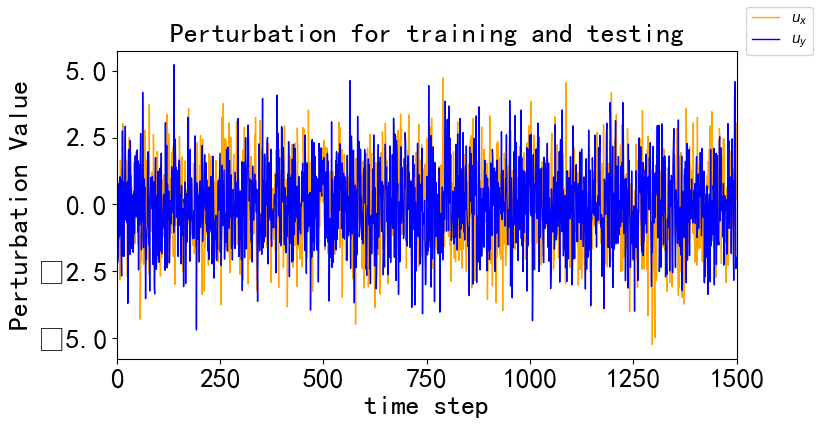

In [11]:
a = 1.5
# u_per_x = - a * np.sin(2*np.pi*freq_x*t_show-4)**3
# u_per_y = - a/epsilon * np.sin(2*np.pi*freq_y*t_show-4)**3

u_per_x = - a * np.random.normal(0,1,train_test_depth)
u_per_y = - a * np.random.normal(0,1,train_test_depth)
u_per = np.array([u_per_x, u_per_y])
zeros = np.zeros((2, wait_time))
u_per_total = np.hstack((zeros, u_per))
# plot perturbation
fontsize = 20
fig, ax = plt.subplots(1, 1, figsize=(8,4))    
ax.plot(u_per[0,:], color = 'orange',linewidth=1, label = r'$u_x$')
ax.plot(u_per[1,:], color = 'blue',linewidth=1, label = r'$u_y$')
# set x and y limits
ax.set_xlim(0,train_test_depth)
# ax.set_ylim(-2*a/epsilon, 2*a/epsilon)

# set x and y labels
ax.set_xlabel('time step',fontsize=fontsize)
ax.set_ylabel('Perturbation Value',fontsize=fontsize)

# set title
ax.set_title('Perturbation for training and testing',fontsize=fontsize)

# adjust ticks
ax.tick_params(axis='both', labelsize=fontsize)    
fig.legend()
# show plot
plt.show()

In [12]:
def generate_perturbed_data(xy0, sigma1, sigma2, epsilon, U, NT, n):
    d = 2
    X_per = np.zeros((d, NT))
    X_per[:,0] = xy0

    # 创造随机项
    N = np.zeros((d, NT))
    np.random.seed(n)
    S = np.sqrt(dt) * np.random.randn(d,NT)

    for i in range(NT - 1):

        # 生成随机扰动
        UUt = S[0, i]
        VVt = S[1, i]

        N[0, i] = sigma1 * UUt  # 为 x 添加噪声
        N[1, i] = (sigma2 / np.sqrt(epsilon)) * VVt  # 为 y 添加噪声

        # 漂移项和扩散项
        f_x = -X_per[1, i]
        f_y = (1/epsilon) * (X_per[1, i] - (1/3) * X_per[1, i]**3 + X_per[0, i])
        

        # 使用欧拉迭代公式更新状态
        X_per[0, i+1] = X_per[0, i] + (f_x + U[0, i]) * dt + N[0, i]
        X_per[1, i+1] = X_per[1, i] + (f_y + U[1, i]) * dt + N[1, i]
        

    return X_per, S, N


In [13]:
# 生成扰动数据
X_per, sto_train_total, noise_train_total= generate_perturbed_data(xy0, sigma1, sigma2, epsilon, u_per_total, data_length, 2 )

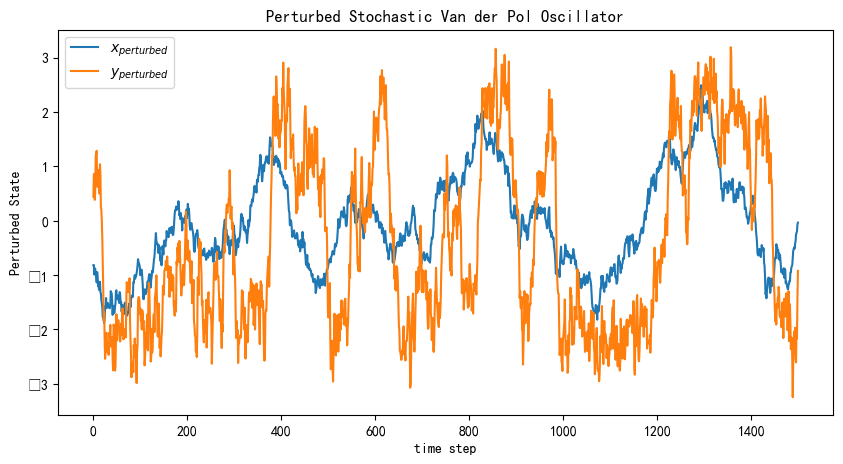

In [14]:

# time-series
plt.figure(figsize=(10, 5))
plt.plot(X_per[0,wait_time:], label=r'$x_{perturbed}$')
plt.plot(X_per[1,wait_time:], label=r'$y_{perturbed}$')
plt.xlabel('time step')
plt.ylabel('Perturbed State')
plt.legend()
plt.title('Perturbed Stochastic Van der Pol Oscillator')



# plt.tight_layout()
plt.show()

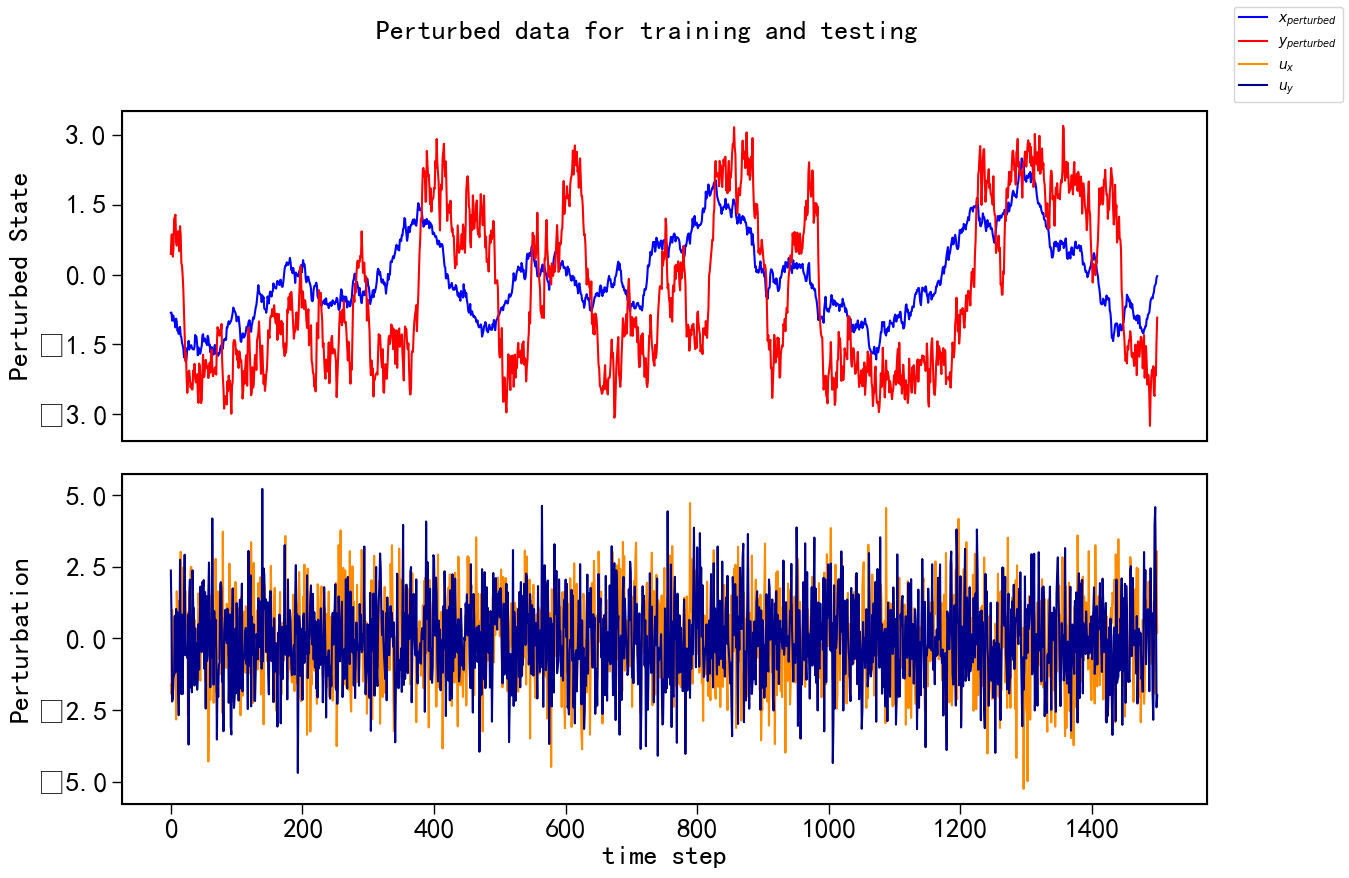

In [15]:
# creating figure
fig, axs = plt.subplots(2, 1, figsize=(14, 9))

# Plot Parameters
fontsize = 20

# plot x and y
axs[0].plot(X_per[0,wait_time:],c='blue', label = r"$x_{perturbed}$")
axs[0].plot(X_per[1,wait_time:],c='red',label = r"$y_{perturbed}$")

# plotting controlled u
axs[1].plot(u_per_x,c='darkorange',label = r"$u_x$")
axs[1].plot(u_per_y,c='darkblue',label = r"$u_y$")
# set y limits
#axs[0].set_ylim(FP.V1_real_min,FP.V1_real_max)
# axs[1].set_ylim(-2*max_uniform, 2*max_uniform)

# set x and y labels
axs[0].set_ylabel("Perturbed State",fontsize = fontsize)
axs[1].set_ylabel("Perturbation",fontsize = fontsize)
axs[1].set_xlabel('time step',fontsize=fontsize)


# adjust ticks for for bottom plots
for ax in axs.flat:
    ax.tick_params(axis='both', labelsize=ticksize)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=nbinsx_time_series))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=nbinsy_time_series))
    ax.tick_params(axis = 'x', which='minor', direction='out', length=tick_length, width=tick_width, colors='black')
    ax.tick_params(axis = 'x', which='major', direction='out', length=tick_length, width=tick_width, colors='black')
    ax.tick_params(axis = 'y', which='minor', direction='out', length=tick_length, width=tick_width, colors='black')
    ax.tick_params(axis = 'y', which='major', direction='out', length=tick_length, width=tick_width, colors='black')
    
    # add boxes around plots
    ax.patch.set_edgecolor('black')  
    ax.patch.set_linewidth(box_linewidth)

# remove x ticks for top plot
axs[0].set_xticks([])

# setting title
fig.suptitle("Perturbed data for training and testing",fontsize=fontsize)

# adding a legend
# fig.legend(bbox_to_anchor=(1.02,0.8),fontsize=fontsize)
fig.legend()
# adjust subplot spacing
plt.subplots_adjust(hspace=0.1)

# plotting figure
plt.show()

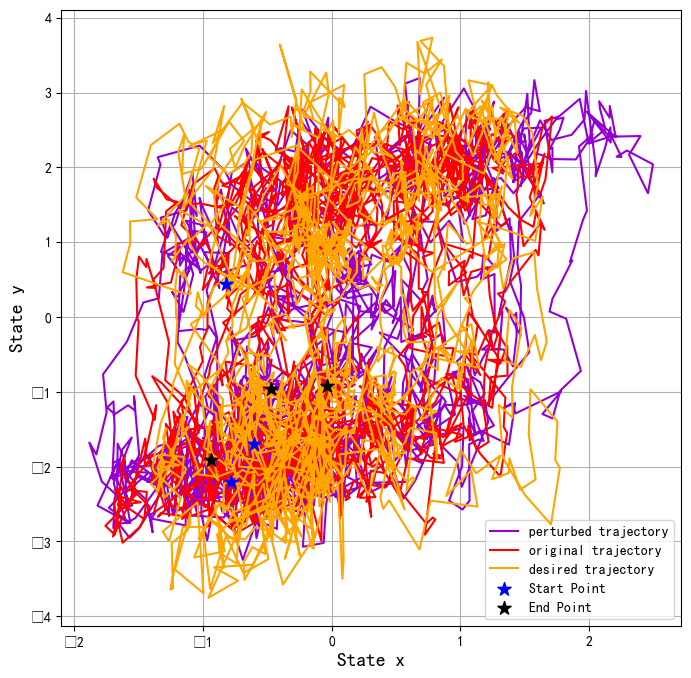

In [16]:

fontsize = 14
# plot attractor
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(X_per[0,wait_time:], X_per[1,wait_time:], c = attractor_color,zorder = 20, label = 'perturbed trajectory')
ax.plot(x, y, c = 'red',zorder = 20, label = 'original trajectory')
ax.plot(x_des, y_des, c = 'orange',zorder = 20, label = 'desired trajectory')
ax.scatter(x[0], y[0],c = 'blue',zorder = 30,marker = '*',s=100)
ax.scatter(x_des[0], y_des[0],c = 'blue',zorder = 30,marker = '*',s=100)
ax.scatter(X_per[0,wait_time], X_per[1,wait_time],c = 'blue',zorder = 30,marker = '*',s=100,label='Start Point')
ax.scatter(x[-1], y[-1],c = 'black',zorder = 30,marker = '*',s=100)
ax.scatter(x_des[-1], y_des[-1],c = 'black',zorder = 30,marker = '*',s=100)
ax.scatter(X_per[0,-1], X_per[1,-1],c = 'black',zorder = 30,marker = '*',s=100, label='End Point')
# setting x and y labels
ax.set_xlabel("State x",fontsize = fontsize)
ax.set_ylabel("State y",fontsize = fontsize)

# # adjust ticks
# ax.tick_params(axis='both', labelsize=ticksize)
# ax.xaxis.set_major_locator(MaxNLocator(nbins=nbinsx_attractor))
# ax.yaxis.set_major_locator(MaxNLocator(nbins=nbinsy_attractor))

# # draw box around plot
# ax.patch.set_edgecolor('black')  
# ax.patch.set_linewidth(box_linewidth)

# setting title
# ax.set_title("三条轨迹的相图比较",fontsize=fontsize)

# plotting figure
ax.legend()
ax.grid(True)
plt.show()


# Training and Testing the NG-RC Model

In [17]:
def training_and_testing(ridge_param,
                         train_pts,
                         test_pts,
                         X_train,
                         U_train,
                         N_train,
                         skip_pts=1,
                         m=1,
                         u_delay=0,
                         show_plots = False,
                         print_code = False):
    # =============================================================================
    # Defining controlled and NG-RC parameters
    # =============================================================================
    
    # # defining controlled gain matrix    
    # K = np.zeros((1,2))
    # # The gain is chosen to be -3.0 to represent the largest magnitude it may ever become,
    # # higher gains like this are used in linear controlled, whereas the NG-RC controlledlers fail
    # # if the gain is |K|>1.0. The fixed-point form for K is chosen based on the maximum value
    # # needed to be represented, so that is why the maximum magnitude is chosen here.
    # K[0,0] = 0.0 # gain for x (not used in this experiment)
    # K[0,1] = -0.3 # gain for y (控制目标)

    # defining useful values for slicing the data    
    skip_pts = 0
    skip_train_pts = skip_pts + train_pts # all skip points and train points
    maxtime_pts = skip_pts + train_pts + test_pts # all skip,train, and test points

    # defining NG-RC parameters
    d = 2 # input dimension: x,y
    k = 2 # number of time delay taps: i,i-1
    dlin = k*d # number of linear features for X: xi,yi,xim1,yim1
    dlinu = 2 # number of linear features for u: uxi,uyi
    dlinn = 2 # number of linear features for u: noise_xi,noise_yi
    # number of nonlinear features: 
    # 
    dtot = dlin + dlinu + dlinn + 30 

    # =============================================================================
    # Linear feature creation
    # =============================================================================
    
    # defining feature vectors
    O_lin = np.zeros((dlin,maxtime_pts)) # linear feature vector
    O_lin_u = np.zeros((dlinu,maxtime_pts)) # linear feature vector (u)
    O_lin_n = np.zeros((dlinn,maxtime_pts)) # linear feature vector (u)
    O_total = np.zeros((dtot,maxtime_pts)) # total feature vector

    # create delayed copy of (x,y)   
    xy_delayed = np.insert(X_train[:,:-1],0,0,axis=1)

            
    # fill in the u feature vector for all times
    # O_lin_u[0,:] = U_train [0,:] # uxi
    # O_lin_u[1,:] = U_train [1,:] # uyi
    # O_lin_n[0,:] = N_train [0,:].squeeze()
    # O_lin_n[1,:] = N_train [1,:].squeeze()
    O_lin_u = U_train 
    O_lin_n = N_train
    # =============================================================================
    # Nonlinear feature creation 
    # =============================================================================

    #lin
    x_i = X_train[0,:]
    y_i = X_train[1,:]
    x_im1 = xy_delayed[0,:]
    y_im1 = xy_delayed[1,:]
    O_lin[:,:] = np.array([x_i, y_i, x_im1, y_im1]).squeeze()

    #nonlin 
    nonlinear_terms = {
        # 二次项（10个）
        "x_i^2": x_i**2,
        "x_i*y_i": x_i * y_i,
        "y_i^2": y_i**2,
        "x_i*x_im1": x_i * x_im1,
        "x_i*y_im1": x_i * y_im1,
        "y_i*x_im1": y_i * x_im1,
        "y_i*y_im1": y_i * y_im1,
        "x_im1^2": x_im1**2,
        "x_im1*y_im1": x_im1 * y_im1,
        "y_im1^2": y_im1**2,

        # 三次项(20个)
        "x_i^3": x_i**3,
        "x_i^2*y_i": x_i**2 * y_i,
        "x_i*y_i^2": x_i * y_i**2,
        "y_i^3": y_i**3,
        "x_i^2*x_im1": x_i**2 * x_im1,
        "x_i^2*y_im1": x_i**2 * y_im1,
        "x_i*y_i*x_im1": x_i * y_i * x_im1,
        "x_i*y_i*y_im1": x_i * y_i * y_im1,
        "y_i^2*x_im1": y_i**2 * x_im1,
        "y_i^2*y_im1": y_i**2 * y_im1,
        "x_i*x_im1^2": x_i * x_im1**2,
        "x_i*x_im1*y_im1": x_i * x_im1 * y_im1,
        "x_i*y_im1^2": x_i * y_im1**2,
        "y_i*x_im1^2": y_i * x_im1**2,
        "y_i*x_im1*y_im1": y_i * x_im1 * y_im1,
        "y_i*y_im1^2": y_i * y_im1**2,
        "x_im1^3": x_im1**3,
        "x_im1^2*y_im1": x_im1**2 * y_im1,
        "x_im1*y_im1^2": x_im1 * y_im1**2,
        "y_im1^3": y_im1**3
    }
    # 将nonlinear_terms的值转换为numpy数组
    O_nonlin= np.array(list(nonlinear_terms.values()))


    O_total[:dlinu,:] = O_lin_u # uxi,uyi
    O_total[dlinu:dlinu+dlinn,:] = O_lin_n 
    O_total[dlinu+dlinn:dlinu+dlinn+dlin,:] = O_lin # xi,yi,xim1,yim1
    # 将nonlinear_array的内容赋值给O_total的后三十维
    O_total[dlinu+dlin+dlinn:,:] = O_nonlin#.squeeze()
    # =============================================================================
    # Learning weights
    # =============================================================================

    # Separating the total feature vector for training and testing
    O_train = O_total[:, skip_pts:skip_train_pts - m]  # Training feature vector
    O_test = O_total[:, skip_train_pts:maxtime_pts - m]  # Testing feature vector

    # Creating truth labels for training and testing sets for both x and y
    Y_train_x = O_lin[0, skip_pts + m:skip_train_pts]  # Ground truth for x during training
    Y_train_y = O_lin[1, skip_pts + m:skip_train_pts]  # Ground truth for y during training

    Y_test_x = O_lin[0, skip_train_pts + m:maxtime_pts]  # Ground truth for x during testing
    Y_test_y = O_lin[1, skip_train_pts + m:maxtime_pts]  # Ground truth for y during testing

    # Stacking x and y labels for training and testing
    Y_train = np.vstack((Y_train_x, Y_train_y))
    Y_test = np.vstack((Y_test_x, Y_test_y))

    # Computing output weights using ridge regression for both x and y
    W_out = (Y_train) @ O_train.T @ np.linalg.pinv(O_train @ O_train.T + ridge_param * np.identity(dtot))

    # Separating learned weights into Wu and WF
    W_u = W_out[:, 0:2]
    W_F = W_out[:, 2:]

    # Finding Wu^-1 for both x and y
    W_u_inv = np.linalg.inv(W_u) 
    # print(W_u_inv@W_u)
    # Convert weights and controlled gain to floating point to be used later
    W_out = W_out
    W_u_inv = W_u_inv

    # Make prediction on training data for both x and y
    train_prediction = W_out @ O_train

    # Compute the training RMSE for both x and y
    train_rmse_x = np.sqrt(np.mean((Y_train_x - train_prediction[0, :]) ** 2))
    train_rmse_y = np.sqrt(np.mean((Y_train_y - train_prediction[1, :]) ** 2))

    # Make prediction on testing data for both x and y
    test_prediction = W_out @ O_test

    # Compute the testing RMSE for both x and y
    test_rmse_x = np.sqrt(np.mean((Y_test_x - test_prediction[0, :]) ** 2))
    test_rmse_y = np.sqrt(np.mean((Y_test_y - test_prediction[1, :]) ** 2))

    # Optionally, you can combine the RMSEs or keep them separate depending on your needs.
    combined_train_rmse = np.sqrt(train_rmse_x**2 + train_rmse_y**2)
    combined_test_rmse = np.sqrt(test_rmse_x**2 + test_rmse_y**2)

    # print(f"Train RMSE (x): {train_rmse_x}, Train RMSE (y): {train_rmse_y}")
    # print(f"Test RMSE (x): {test_rmse_x}, Test RMSE (y): {test_rmse_y}")


    # =============================================================================
    # Plotting training and testing predictions
    # =============================================================================
    
    if show_plots:
        fontsize = 18
        # =============================================================================
        # Plotting training attractor 
        # =============================================================================
        
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        ax.plot(O_lin[0,skip_pts+m:skip_train_pts],O_lin[1,skip_pts+m:skip_train_pts], c = 'C0',zorder = 1, label = 'true')
        ax.plot(train_prediction[0,:],train_prediction[1,:], c = 'red',zorder = 10, label = 'predicted')

        # setting x and y labels
        ax.set_xlabel(r"$x_{train}$",fontsize = fontsize)
        ax.set_ylabel(r"$y_{train}$",fontsize = fontsize)
        
        # add title
        ax.set_title('Prediction on training data',fontsize=fontsize)
        
        # setting x and y limits
        # ax.set_xlim(FP.SM1_12_TYPE.lower,FP.SM1_12_TYPE.upper)
        # ax.set_ylim(FP.SM1_12_TYPE.lower,FP.SM1_12_TYPE.upper)

        # adjust ticks
        ax.tick_params(axis='both', labelsize=ticksize)
        ax.xaxis.set_major_locator(MaxNLocator(nbins=nbinsx_attractor))
        ax.yaxis.set_major_locator(MaxNLocator(nbins=nbinsy_attractor))

        # draw box around plot
        ax.patch.set_edgecolor('black')  
        ax.patch.set_linewidth(box_linewidth)
        
        # add legend
        ax.legend(bbox_to_anchor = (1,1),fontsize=fontsize)

        # plotting figure
        plt.show()

        # =============================================================================
        # Plotting training time-series 
        # =============================================================================

        # subplots
        fig, axs = plt.subplots(3, 1, figsize=(10,8))
        axs[0].plot(O_lin[0,skip_pts+m:skip_train_pts], c = 'C0', label = r"true $x_{train}$")
        axs[0].plot(train_prediction[0,:], c = "red", label = r"predicted $x_{train}$")
        axs[1].plot(O_lin[1,skip_pts+m:skip_train_pts], c = 'blue',label = r"true $y_{train}$")
        axs[1].plot(train_prediction[1,:], c = "red", label = r"predicted $y_{train}$")
        axs[2].plot(O_lin_u[0,skip_pts+m:skip_train_pts], label = r"u_x", c = "darkorange")
        axs[2].plot(O_lin_u[1,skip_pts+m:skip_train_pts], label = r"u_y", c = "darkblue")
        # set x and y labels
        axs[0].set_ylabel(r"$x_{train}$",fontsize=fontsize)
        axs[1].set_ylabel(r"$y_{train}$",fontsize=fontsize)
        axs[2].set_ylabel(r"u ",fontsize=fontsize)
        axs[2].set_xlabel("time step",fontsize=fontsize)
        
        for ax in axs.flat:
            # adjust ticks
            ax.tick_params(axis='both', labelsize=ticksize)
            ax.xaxis.set_major_locator(MaxNLocator(nbins=nbinsx_time_series))
            ax.yaxis.set_major_locator(MaxNLocator(nbins=nbinsy_time_series))

            # draw box around plot
            ax.patch.set_edgecolor('black')  
            ax.patch.set_linewidth(box_linewidth)
            
        # remove ticks on V1 and V2 plots
        axs[0].set_xticks([])
        axs[1].set_xticks([])
        
        # adjust subplot spacing
        plt.subplots_adjust(hspace=0.1)
        
        # set title
        fig.suptitle("Prediction on training data",fontsize=fontsize)
        
        # add legend
        fig.legend(bbox_to_anchor = (1.2,0.9),fontsize = fontsize)
        
        # show plot
        plt.show()

        # =============================================================================
        # Plotting training error
        # =============================================================================

        fig, ax = plt.subplots(1, 1, figsize=(10,6))
        ax.plot(train_prediction[0,:] - O_lin[0,skip_pts+m:skip_train_pts],c='C0', label = r'error $x_{train}$')
        ax.plot(train_prediction[1,:] - O_lin[1,skip_pts+m:skip_train_pts],c='blue', label = r'error $y_{train}$')
       
        # set x and y labels
        ax.set_ylabel(" error",fontsize=fontsize)
        ax.set_xlabel("time step",fontsize=fontsize)
        
        # adjust ticks
        ax.tick_params(axis='both', labelsize=ticksize)
        ax.xaxis.set_major_locator(MaxNLocator(nbins=nbinsx_time_series))
        ax.yaxis.set_major_locator(MaxNLocator(nbins=nbinsy_time_series))

        # draw box around plot
        ax.patch.set_edgecolor('black')  
        ax.patch.set_linewidth(box_linewidth)
        
        # add title
        ax.set_title("Training error",fontsize=fontsize)
        
        # show plot
        fig.legend(fontsize=fontsize)
        plt.show()

        # WIP below
        
        # =============================================================================
        # Plotting testing attractor
        # =============================================================================
        
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        ax.plot(O_lin[0,skip_train_pts+m:maxtime_pts],O_lin[1,skip_train_pts+m:maxtime_pts], c = 'C0',zorder = 1, label = 'true')
        ax.plot(test_prediction[0,:],test_prediction[1,:], c = 'red',zorder = 10, label = 'predicted')

        # setting x and y labels
        ax.set_xlabel(r"$x_{test}$", fontsize=fontsize)
        ax.set_ylabel(r"$y_{test}$", fontsize=fontsize)

        
        # add title
        ax.set_title('Prediction on testing data',fontsize=fontsize)
        
        # setting x and y limits
        # ax.set_xlim(FP.SM1_12_TYPE.lower,FP.SM1_12_TYPE.upper)
        # ax.set_ylim(FP.SM1_12_TYPE.lower,FP.SM1_12_TYPE.upper)

        # adjust ticks
        ax.tick_params(axis='both', labelsize=ticksize)
        ax.xaxis.set_major_locator(MaxNLocator(nbins=nbinsx_attractor))
        ax.yaxis.set_major_locator(MaxNLocator(nbins=nbinsy_attractor))

        # draw box around plot
        ax.patch.set_edgecolor('black')  
        ax.patch.set_linewidth(box_linewidth)
        
        # add legend
        ax.legend(bbox_to_anchor = (1,0.8),fontsize=fontsize)

        # plotting figure
        plt.show()
        
        # =============================================================================
        # Plotting testing time-series 
        # =============================================================================

        # subplots
        fig, axs = plt.subplots(3, 1, figsize=(10,8))
        axs[0].plot(O_lin[0,skip_train_pts+m:maxtime_pts],'*', c = 'C0', label = r'true $x_{test}$')
        axs[0].plot(test_prediction[0,:], c = "red", label = r'predicted $x_{test}$')
        axs[1].plot(O_lin[1,skip_train_pts+m:maxtime_pts], '*',c = 'blue',label = r'true $y_{test}$')
        axs[1].plot(test_prediction[1,:], c = "red", label = r'predicted $y_{test}$')
        axs[2].plot(O_lin_u[0,skip_train_pts+m:maxtime_pts], label = r"$u_x$", c = "darkorange")
        axs[2].plot(O_lin_u[1,skip_train_pts+m:maxtime_pts], label = r"$u_y$", c = "darkblue")
        # set x and y labels
        axs[0].set_ylabel(r"$x_{eset}$",fontsize=fontsize)
        axs[1].set_ylabel(r"$y_{eset}$",fontsize=fontsize)
        axs[2].set_ylabel('u',fontsize=fontsize)
        axs[2].set_xlabel("time step",fontsize=fontsize)
        
        for ax in axs.flat:
            # adjust ticks
            ax.tick_params(axis='both', labelsize=ticksize)
            ax.xaxis.set_major_locator(MaxNLocator(nbins=nbinsx_time_series))
            ax.yaxis.set_major_locator(MaxNLocator(nbins=nbinsy_time_series))

            # draw box around plot
            ax.patch.set_edgecolor('black')  
            ax.patch.set_linewidth(box_linewidth)
            
        # remove ticks on V1 and V2 plots
        axs[0].set_xticks([])
        axs[1].set_xticks([])
        
        # adjust subplot spacing
        plt.subplots_adjust(hspace=0.1)
        
        # set title
        # fig.suptitle("测试数据上的预测结果",fontsize=fontsize)
        
        # add legend
        fig.legend(bbox_to_anchor = (1,0.9),fontsize = fontsize)
        
        # show plot
        plt.show()
        
        # =============================================================================
        # Plotting testing error 
        # =============================================================================
        # plot_test_error = test_prediction[:,:] - O_lin[:2,skip_train_pts+m:maxtime_pts]

        fig, ax = plt.subplots(1, 1, figsize=(10,6))
        ax.plot(test_prediction[0,:] - O_lin[0,skip_train_pts+m:maxtime_pts],c='C0', label = r'error $x_{test}$')
        ax.plot(test_prediction[1,:] - O_lin[1,skip_train_pts+m:maxtime_pts],c='blue', label =r'error $y_{test}$')
        # set x and y labels
        ax.set_ylabel("error ",fontsize=fontsize)
        ax.set_xlabel("time step",fontsize=fontsize)
        
        # adjust ticks
        ax.tick_params(axis='both', labelsize=ticksize)
        ax.xaxis.set_major_locator(MaxNLocator(nbins=nbinsx_time_series))
        ax.yaxis.set_major_locator(MaxNLocator(nbins=nbinsy_time_series))

        # draw box around plot
        ax.patch.set_edgecolor('black')  
        ax.patch.set_linewidth(box_linewidth)
        
        # add title
        # ax.set_title("测试数据上的预测误差",fontsize=fontsize)
        
        # show plot
        fig.legend(bbox_to_anchor = (1,0.9),fontsize = fontsize)
        plt.show()

    
    # keeping training and testing results in a dictionary
    train_test_dict = {'ridge_param':ridge_param,
                       'train_rmse':combined_train_rmse,
                       'test_rmse': combined_test_rmse,
                       'W_out':W_out,
                       'W_u_inv':W_u_inv,
                       'plot_test_error':test_prediction[:,:] - O_lin[:2,skip_train_pts+m:maxtime_pts]}
    # =============================================================================
    # Print code to paste into Verilog file in Quartus
    # =============================================================================

    if print_code:
        print("Printing code:\n")
        # get the current date and time to mark when the weights were learned
        current_time = datetime.now()
        formatted_time = current_time.strftime("%m/%d/%Y %I:%M %p")


        print("Done printing code")
        print("//******************************************LOCAL PARAMETERS******************************************//\n")
        print(f"//Weights (trained on {formatted_time})")
        

        print("localparam train_test_depth = " + str(train_test_depth) + ";")
 
        
        print("\n//******************************************Train Output******************************************//\n")
        
        print("\n// KEEP OTHER DECLARATIONS CONSTANT IN CODE\n")
            
        print(f"\n//Weights (trained on {formatted_time})")
        print("//ridge parameter: " + str(ridge_param))
        print("W_u_inv = " + str(W_u_inv[:,0:2])) 
        print("W_u_x = " + str(W_out[:,0]))
        print("W_u_y = " + str(W_out[:,1] )) 
        print("W_n_x = " + str(W_out[:,2] ) )
        print("W_n_y = " + str(W_out[:,3] ) )

    return train_test_dict



# Find the ridge parameter that gives lowest testing error

In [18]:
# ridge_param_vs_best_test_ridge
def evaluate_param(ridge_param_array, train_pts, test_pts, 
                   perturbed_data, u_per, noise, m=1):
    """
    Evaluate the best test ridge parameter for given ridge parameters.
    
    Parameters:
    - ridge_param_array: Array of ridge parameters to evaluate.
    - train_pts: Number of training points.
    - test_pts: Number of testing points.
    - perturbed_data: The perturbed data used for training and testing.
    - u_per: The controlled input for the model.
    - m: The number of steps ahead for prediction (default is 1).

    Returns:
    - best_test_ridges: The list of best test ridge parameters corresponding to each ridge parameter.
    - spectral_radii: The list of spectral radii corresponding to each ridge parameter.
    """

    # 保存不同岭回归参数的最佳结果
    results = []
    # 定义用于存储训练和测试 RMSE 的数组
    rmse_train_array = np.zeros(len(ridge_param_array))
    rmse_test_array = np.zeros(len(ridge_param_array))
    # 遍历不同的岭回归参数
    for i in range(len(ridge_param_array)):
        ridge_param = ridge_param_array[i]

        # 执行训练和测试
        train_test_dict_i = training_and_testing(ridge_param,
                                                 train_pts,
                                                 test_pts,
                                                 perturbed_data,
                                                 u_per,
                                                 noise,
                                                 m=m)

        # 保存训练和测试的 RMSE
        rmse_train_array[i] = train_test_dict_i['train_rmse']
        rmse_test_array[i] = train_test_dict_i['test_rmse']


    # 找到最小的测试 RMSE
    best_test_rmse = np.min(rmse_test_array)

    # 找到对应的最佳岭回归参数
    best_test_ridge = ridge_param_array[np.argmin(rmse_test_array)]

    # 保存对应的最佳测试结果
    train_test_dict = training_and_testing(best_test_ridge,
                                            train_pts,
                                            test_pts,
                                            perturbed_data,
                                            u_per,
                                            noise,
                                            m=m,
                                            show_plots=False,
                                            print_code=False)

    # 计算并保存谱半径
    spectral_radius = np.max(np.abs(np.linalg.eigvals(train_test_dict['W_u_inv'][:, 0:2])))
    print('最小的测试 RMSE:', best_test_rmse)
    print('对应的最佳岭回归参数:', best_test_ridge)
    print('W_u_inv矩阵对应的谱半径:', spectral_radius)

    return best_test_ridge


In [19]:

m = 1 # one step ahead prediction
# 定义搜索区间和总次数
ridge_param_array = np.logspace(-10,1,100)

# serachleak best_test_ridges
best_test_ridge = evaluate_param(
    ridge_param_array, train_pts, test_pts, X_per[:,wait_time:], u_per, noise_train_total[:,wait_time:], m)



最小的测试 RMSE: 1.2314610277821257e-10
对应的最佳岭回归参数: 2.782559402207126e-10
W_u_inv矩阵对应的谱半径: 100.00000000131013


In [22]:
print_code = True
# save the training and testing results that correspond to the lowest testing error.
train_test_dict = training_and_testing(best_test_ridge,
                                       train_pts,
                                       test_pts,
                                       X_per[:,wait_time:],
                                       u_per,
                                       noise_train_total[:,wait_time:],
                                       m=m,
                                       show_plots=False, 
                                       print_code=print_code)

Printing code:

Done printing code
//******************************************LOCAL PARAMETERS******************************************//

//Weights (trained on 06/15/2025 04:20 PM)
localparam train_test_depth = 1500;

//******************************************Train Output******************************************//


// KEEP OTHER DECLARATIONS CONSTANT IN CODE


//Weights (trained on 06/15/2025 04:20 PM)
//ridge parameter: 2.782559402207126e-10
W_u_inv = [[ 1.00000000e+02 -1.06617968e-10]
 [-2.75458331e-10  1.00000000e+02]]
W_u_x = [1.00000000e-02 2.75458331e-14]
W_u_y = [1.06617968e-14 1.00000000e-02]
W_n_x = [1.00000000e+00 1.27587118e-12]
W_n_y = [-1.84352669e-13  1.00000000e+00]


In [23]:
# svd 分解 W_out
A = train_test_dict['W_out']
# Perform SVD
U, S, Vt = np.linalg.svd(A)

# Print the results
print("U matrix:")
print(U)
print("\nSingular values:")
print(S)
print("\nVt matrix:")
print(Vt)


U matrix:
[[ 0.3325529  0.9430846]
 [ 0.9430846 -0.3325529]]

Singular values:
[1.50086459 1.40314525]

Vt matrix:
[[ 2.21574221e-03  6.28360885e-03  2.21574221e-01 ... -6.59994095e-11
  -1.54476838e-11 -7.76250688e-12]
 [ 6.72121865e-03 -2.37005329e-03  6.72121865e-01 ... -4.12171220e-11
  -8.59807961e-11  6.54804494e-12]
 [-7.07080236e-01  2.96721617e-02  5.02679431e-01 ...  4.20388621e-11
   6.07794598e-11 -2.66039342e-12]
 ...
 [ 6.18429986e-11  4.72251626e-11  4.20284792e-11 ...  1.00000000e+00
  -4.53082653e-21 -2.41059993e-22]
 [ 8.59048864e-11 -1.58643743e-11  6.07820148e-11 ... -4.53231143e-21
   1.00000000e+00  4.39793247e-22]
 [-3.39008795e-12  9.57291613e-12 -2.66235883e-12 ... -2.40838313e-22
   4.40019780e-22  1.00000000e+00]]


In [24]:
B = train_test_dict['W_out'][:,:2]
np.linalg.cond(B)

np.float64(1.0000000000137474)

重要性: 较大的奇异值对应更重要的特征方向，较小的奇异值则对应较弱的特征方向。

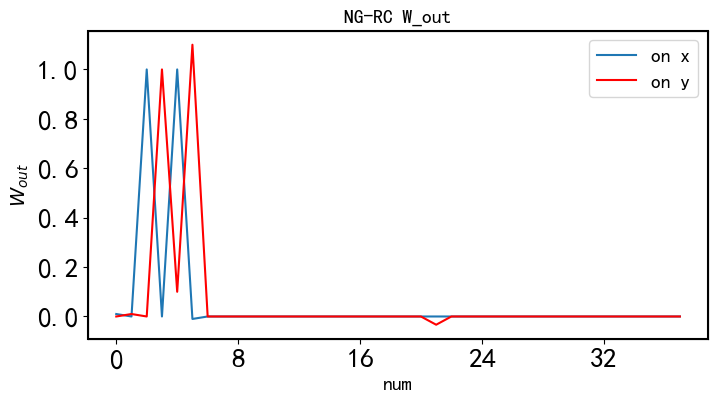

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(np.arange(len(A.T)),A[0].T, c = 'C0',zorder = 1, label = 'on x')
ax.plot(np.arange(len(A.T)),A[1].T, c = 'red',zorder = 1, label = 'on y')

# setting x and y labels
ax.set_xlabel(r"num",fontsize = fontsize)
ax.set_ylabel(r"$W_{out}$",fontsize = fontsize)

# add title
ax.set_title('NG-RC W_out',fontsize=fontsize)

# setting x and y limits
# ax.set_xlim(FP.SM1_12_TYPE.lower,FP.SM1_12_TYPE.upper)
# ax.set_ylim(FP.SM1_12_TYPE.lower,FP.SM1_12_TYPE.upper)

# adjust ticks
ax.tick_params(axis='both', labelsize=ticksize)
ax.xaxis.set_major_locator(MaxNLocator(nbins=nbinsx_attractor))
ax.yaxis.set_major_locator(MaxNLocator(nbins=nbinsy_attractor))

# draw box around plot
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth(box_linewidth)

# add legend
ax.legend(bbox_to_anchor = (1,1),fontsize=fontsize)

# plotting figure
plt.show()

## plot train

C:\Users\cheng\AppData\Local\Temp\ipykernel_39168\473145792.py:48: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  plt.tight_layout()
c:\Users\cheng\.conda\envs\openv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


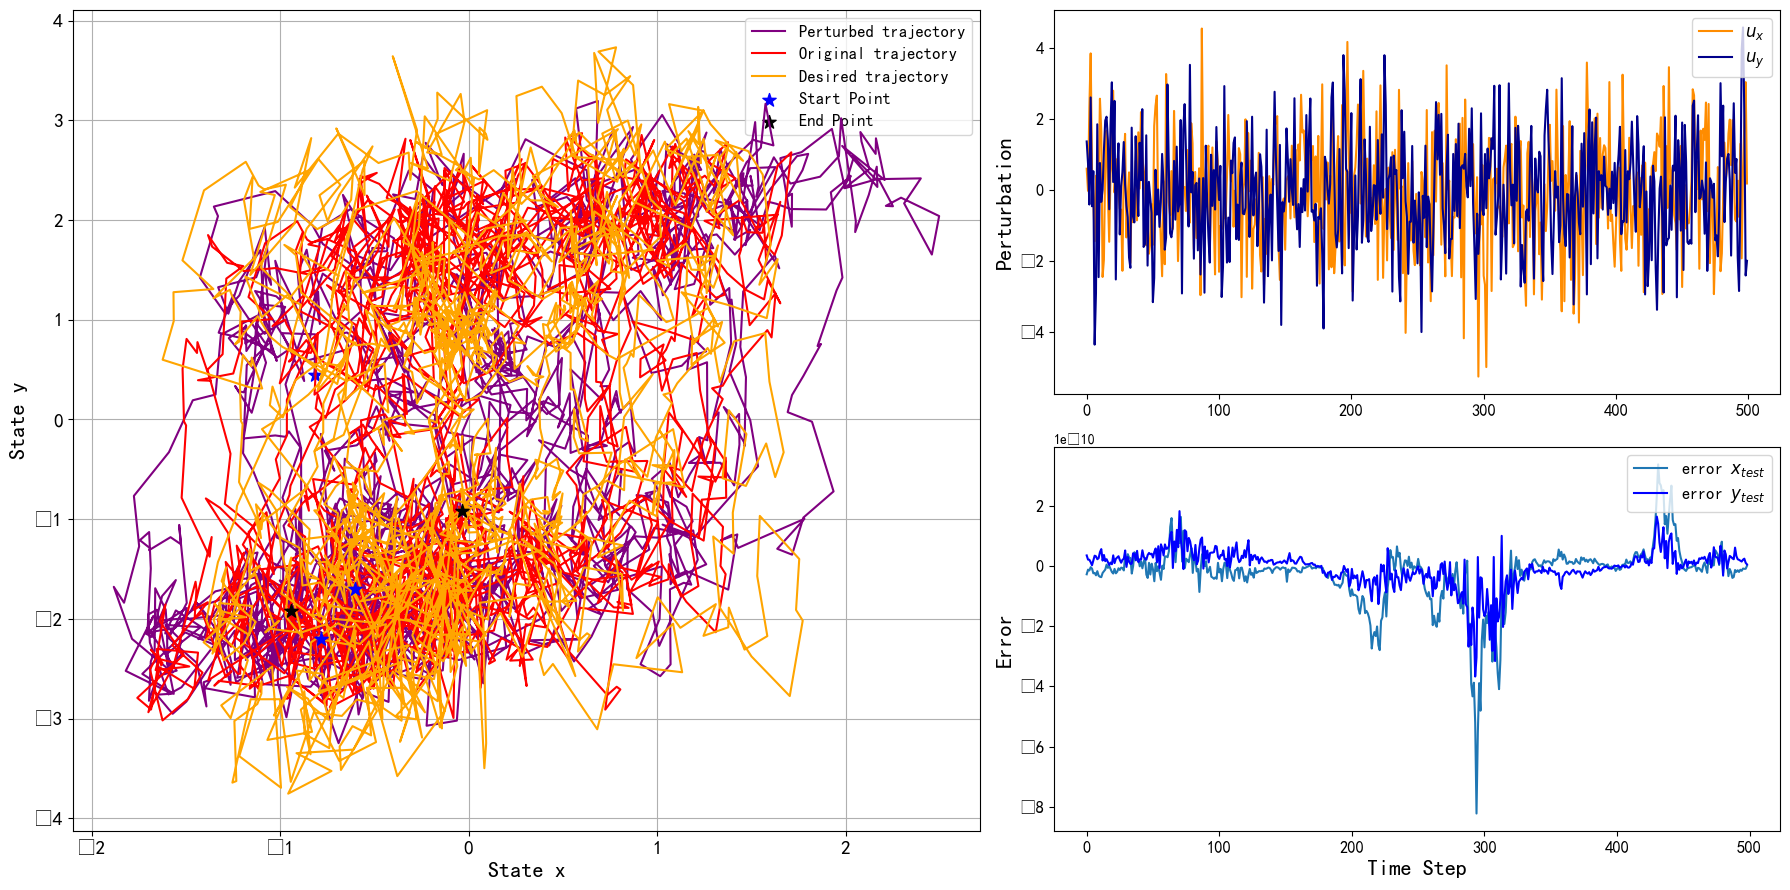

In [26]:


test_error = train_test_dict['plot_test_error']

import matplotlib.gridspec as gridspec

# 创建网格布局
fig = plt.figure(figsize=(18, 9))  # 总画布尺寸
gs = gridspec.GridSpec(2, 2, width_ratios=[5, 4], height_ratios=[1, 1])  # 2行2列

fontsize = 16  # 统一字体大小

### 1️⃣ 相图 (左侧, 占据两行)
ax0 = fig.add_subplot(gs[:, 0])  # 选中整个左侧区域
ax0.plot(X_per[0, wait_time:], X_per[1, wait_time:], c='purple', label='Perturbed trajectory', zorder=20)
ax0.plot(x, y, c='red', label='Original trajectory', zorder=20)
ax0.plot(x_des, y_des, c='orange', label='Desired trajectory', zorder=20)
ax0.scatter(x[0], y[0], c='blue', marker='*', s=100, zorder=30)
ax0.scatter(x_des[0], y_des[0], c='blue', marker='*', s=100, label='Start Point', zorder=30)
ax0.scatter(X_per[0, wait_time], X_per[1, wait_time], c='blue', marker='*', s=100)
ax0.scatter(x[-1], y[-1], c='black', marker='*', s=100, zorder=30)
ax0.scatter(x_des[-1], y_des[-1], c='black', marker='*', s=100)
ax0.scatter(X_per[0, -1], X_per[1, -1], c='black', marker='*', s=100, label='End Point', zorder=30)

# 设置标签和刻度
ax0.set_xlabel("State x", fontsize=fontsize)
ax0.set_ylabel("State y", fontsize=fontsize)
ax0.legend(fontsize=12, loc='upper right')
ax0.grid(True)
ax0.tick_params(axis='both', labelsize=14)  # 坐标刻度大小

### 2️⃣ 右上角 Perturbation 时序图
ax1 = fig.add_subplot(gs[0, 1])
ax1.plot(u_per_x[train_pts:train_pts+test_pts], c='darkorange', label=r"$u_x$")
ax1.plot(u_per_y[train_pts:train_pts+test_pts], c='darkblue', label=r"$u_y$")
ax1.set_ylabel("Perturbation", fontsize=fontsize)
ax1.legend(fontsize=12, loc='upper right')
ax1.tick_params(axis='both', labelsize=12)  # 坐标刻度大小

### 3️⃣ 右下角 Error 时序图
ax2 = fig.add_subplot(gs[1, 1])
ax2.plot(test_error[0], c='C0', label=r'error $x_{test}$')
ax2.plot(test_error[1], c='blue', label=r'error $y_{test}$')
ax2.set_ylabel("Error", fontsize=fontsize)
ax2.set_xlabel("Time Step", fontsize=fontsize)
ax2.legend(fontsize=12, loc='upper right')
ax2.tick_params(axis='both', labelsize=12)

# 调整布局
plt.tight_layout()
plt.show()


# Do control

In [27]:
def do_control(W_u_inv, Weight, Y_desired, N_total, S, xy0, K, control_length, control_wait):
    """

    
    Parameters:
        K (numpy.ndarray): The controlled gain matrix (2x2).
        delay_level (int): The amount of delay in microseconds to add before
        the controlled perturbation is applied.
        task (int): Specifies the desired signal (1: original, 2: USS, 3: random).
        feedback_linearization (int): Whether the controlledler is strictly
        linear (0) or contains nonlinear terms (1).
        Y_desired (numpy.ndarray): desired signal in digital form.
        
    Returns:
        controlled_dict (dict): A dictionary containing controlled data, desired signal,
        controlled series, controlled RMSE, and time array.
    """
    

 

    # Load pre-trained weights
    W_N = Weight[:, 2:4]  
    W_X = Weight[:, 4:]  

    # NG-RC parameters
    d = 2  # input dimension: x, y
    k = 2  # number of time delay taps
    dlin = k * d  # number of linear features for X
    
    dX = dlin + 30  # total features including nonlinear terms

    # =============================================================================
    # feature creation
    # =============================================================================
    
    O_X = np.zeros((dX,1)) # 去掉控制u_i、u_im1的其他 feature vector
    O_N = np.zeros((d,1))
    #初始条件
    u_con = np.array([0, 0])[:, np.newaxis]
    e_i = np.array([0, 0])[:, np.newaxis]
    X_con = np.zeros((d, control_length))
    X_con[:, 0] = xy0

  
    #储存轨迹和控制
    error_series = e_i
    controlled_series = u_con
    #迭代更新(只更新一步，根据结果可调整)
    for i in range(control_length-1):#data_length-1
        # 计算控制序列
        if i >= control_wait-1:
            x_i, y_i = X_con[0, i], X_con[1, i]
            x_im1, y_im1 = X_con[0, i-1], X_con[1, i-1]
            # Linear features
            O_lin = np.array([x_i, y_i, x_im1, y_im1]) 
            # Nonlinear features
            nonlinear_terms = {
                "x_i^2": x_i**2, "x_i*y_i": x_i * y_i, "y_i^2": y_i**2,
                "x_i*x_im1": x_i * x_im1, "x_i*y_im1": x_i * y_im1,
                "y_i*x_im1": y_i * x_im1, "y_i*y_im1": y_i * y_im1,
                "x_im1^2": x_im1**2, "x_im1*y_im1": x_im1 * y_im1, "y_im1^2": y_im1**2,
                "x_i^3": x_i**3, "x_i^2*y_i": x_i**2 * y_i, "x_i*y_i^2": x_i * y_i**2,
                "y_i^3": y_i**3, "x_i^2*x_im1": x_i**2 * x_im1,
                "x_i^2*y_im1": x_i**2 * y_im1, "x_i*y_i*x_im1": x_i * y_i * x_im1,
                "x_i*y_i*y_im1": x_i * y_i * y_im1, "y_i^2*x_im1": y_i**2 * x_im1,
                "y_i^2*y_im1": y_i**2 * y_im1, "x_i*x_im1^2": x_i * x_im1**2,
                "x_i*x_im1*y_im1": x_i * x_im1 * y_im1, "x_i*y_im1^2": x_i * y_im1**2,
                "y_i*x_im1^2": y_i * x_im1**2, "y_i*x_im1*y_im1": y_i * x_im1 * y_im1,
                "y_i*y_im1^2": y_i * y_im1**2, "x_im1^3": x_im1**3,
                "x_im1^2*y_im1": x_im1**2 * y_im1, "x_im1*y_im1^2": x_im1 * y_im1**2,
                "y_im1^3": y_im1**3
            }
            # 将nonlinear_terms的值转换为numpy数组
            O_nonlin= np.array(list(nonlinear_terms.values()))
            
            # Total feature vector
            O_X[:dlin] = O_lin[:, np.newaxis] # xi,yi,xim1,yim1
            O_X[dlin:] = O_nonlin[:, np.newaxis]

            O_N[0] = sigma1 * S[0,i-wait_time]
            O_N[1] = (sigma2 / np.sqrt(epsilon)) * S[1,i-wait_time]
            # Calculate prediction error and update controlled input
            e_i = Y_desired[:, i][:, np.newaxis] - X_con[:, i][:, np.newaxis]
            # print(i,'---e_i.shape:',e_i.shape,'---u_con.shape:',u_con.shape, '----Y_desired[:, i].shape:',Y_desired[:, i].shape, '----X_con[:, i].shape:',X_con[:, i].shape)
            # print('---W_u_inv.shape:',W_u_inv.shape,'---W_X.shape:',W_X.shape,'---O_X.shape:',O_X.shape, '---W_N.shape:',W_N.shape,'---O_N.shape:',O_N.shape)     
            u_con = W_u_inv @ (Y_desired[:, i + 1][:, np.newaxis] - W_X @ O_X - W_N @ O_N + K @ e_i)
            # print(i,'---e_i:',e_i,'---u_con',u_con)
            # print('---Y_desired[:, i + 1]:',Y_desired[:, i + 1],'---O_X:',O_X)
            error_series = np.hstack((error_series, e_i))
            controlled_series = np.hstack((controlled_series, u_con))
            # print(controlled_series.shape)


        f_x = -X_con[1, i]
        f_y = (1/epsilon) * (X_con[1, i] - (1/3) * X_con[1, i]**3 + X_con[0, i])
        if i < control_wait-1:
            #无控制时模拟当前状态下的系统
            X_con[0, i+1] = X_con[0, i] + f_x * dt + N_total[0, i]
            X_con[1, i+1] = X_con[1, i] + f_y * dt + N_total[1, i]
            
        else:
            # 生成随机扰动
            UUt = np.sqrt(dt) * np.random.randn()
            VVt = np.sqrt(dt) * np.random.randn()

            a = sigma1 * UUt  # 为 x 添加噪声
            b = (sigma2 / np.sqrt(epsilon)) * VVt  # 为 y 添加噪声
            #控制时模拟当前状态下的系统
            X_con[0, i+1] = X_con[0, i] + (f_x + u_con[0]) * dt + a
            X_con[1, i+1] = X_con[1, i] + (f_y + u_con[1]) * dt + b

        

    # calculate the controlled RMSE 
    rmse_total = np.sqrt(np.mean((Y_desired[:,wait_time:-1] - X_con[:,wait_time:-1])**2))
    rmse_x = np.sqrt(np.mean((Y_desired[0,wait_time:-1] - X_con[0,wait_time:-1])**2))
    rmse_y = np.sqrt(np.mean((Y_desired[1,wait_time:-1] - X_con[1,wait_time:-1])**2))
    controlled_rmse = np.array([rmse_total,rmse_x,rmse_y])
    # Store controlled data in a dictionary
    
    # 填充controlled_wait中的0控制
    zeros = np.zeros((2, control_wait-1))
    controlled_result = np.hstack((zeros, controlled_series))
    errors = np.hstack((zeros, error_series))
    # print('X_con.shape:',X_con.shape)
    # print('Y_desired.shape:',Y_desired.shape)
    # print('controlled_result.shape:',controlled_result.shape)
    # print('controlled_rmse:',controlled_rmse)
    # print('errors.shape:',errors.shape)

    controlled_dict = {'Data_controlled':X_con,
                    'Y_desired':Y_desired,
                    'controlled_series':controlled_result,
                    'controlled_rmse':controlled_rmse,
                    'controlled error':errors
                    }

    return controlled_dict

# control  system

In [28]:
# set controlled parameters
K = np.zeros((2,2))
# The gain is chosen to be -3.0 to represent the largest magnitude it may ever become,
# higher gains like this are used in linear controlled, whereas the NG-RC controlledlers fail
# if the gain is |K|>1.0. The fixed-point form for K is chosen based on the maximum value
# needed to be represented, so that is why the maximum magnitude is chosen here.

K[0,0] = -0.3 # gain for x (not used in this experiment)
K[1,1] = -0.5 # gain for y (控制目标)
delay_level = 0 # set the added delay in the controlled loop in microseconds

# determine whether the controlledler is linear or uses NG-RC (1:NG-RC)
feedback_linearization = 1

W_u_inv = train_test_dict['W_u_inv']
W_out = train_test_dict['W_out']

controlled_dict = do_control(W_u_inv,
                            W_out,
                            Y_desired,
                            noise_origin_total,
                            sto_train_total,
                            xy0,
                            K,
                            data_length,
                            t1)

C:\Users\cheng\AppData\Local\Temp\ipykernel_39168\1711975668.py:110: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_con[0, i+1] = X_con[0, i] + (f_x + u_con[0]) * dt + a
C:\Users\cheng\AppData\Local\Temp\ipykernel_39168\1711975668.py:111: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_con[1, i+1] = X_con[1, i] + (f_y + u_con[1]) * dt + b


# Plot control results

In [29]:
t1,t2,t3 = controlled_wait1+wait_time,transient_end1+controlled_wait2,transient_end2+controlled_wait3
x = controlled_dict['Data_controlled']
u = controlled_dict['controlled_series']
e = controlled_dict['controlled error']
rmse = controlled_dict['controlled_rmse']

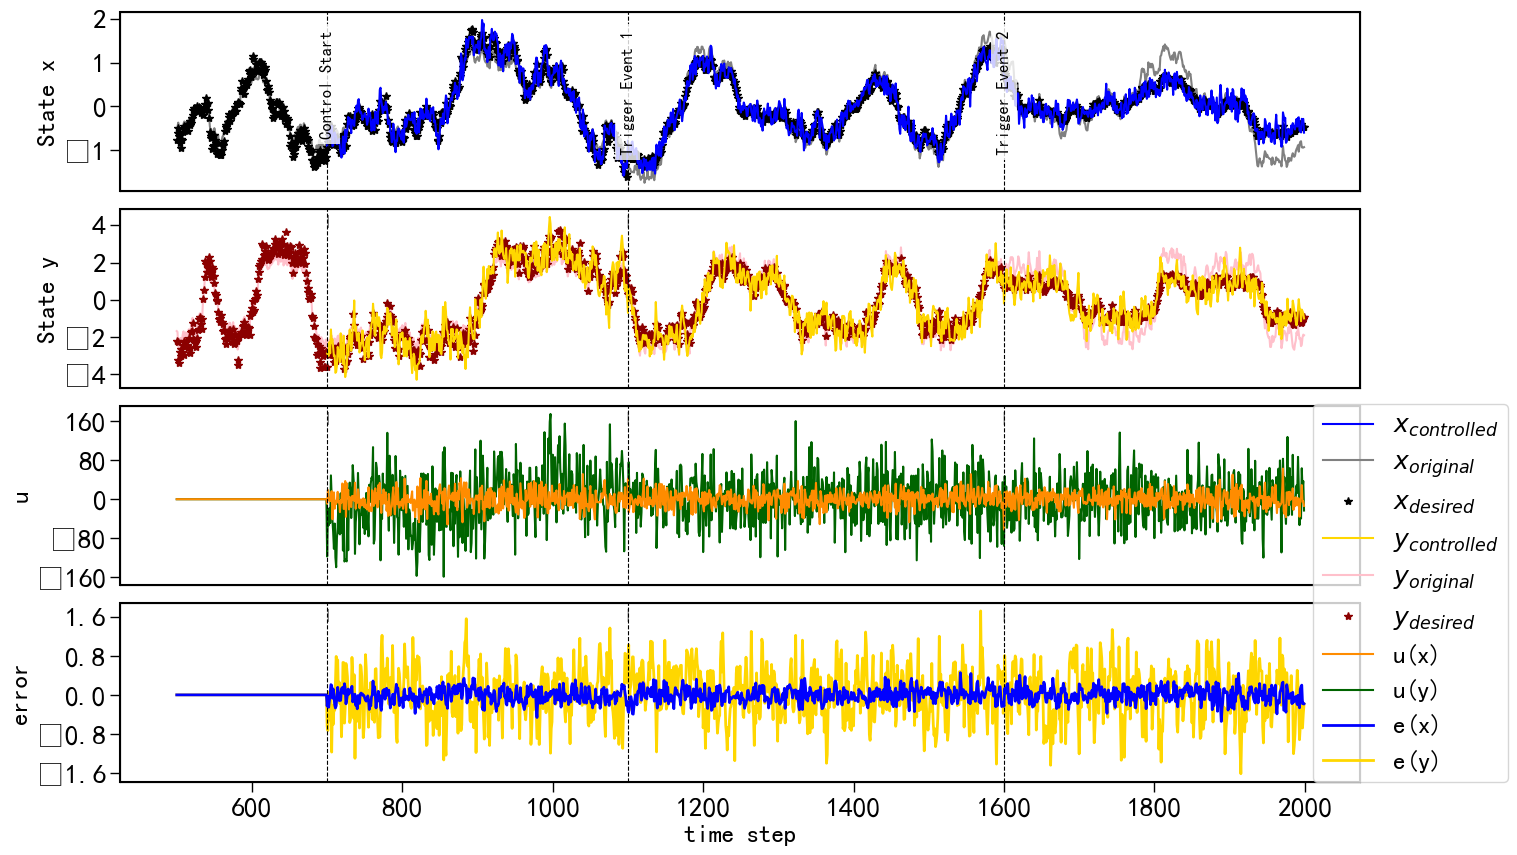

In [30]:
# creating figure
fig, axs = plt.subplots(4, 1, figsize=(16, 10))

# plotting controlled V1 and V2 in first bottom subplot
axs[0].plot(time_array[t1:data_length],
            x[0][t1:data_length],
            c='blue', label = r'$x_{controlled}$')
axs[1].plot(time_array[t1:data_length],
            x[1][t1:data_length],
            c='gold',label = r'$y_{controlled}$')
axs[0].plot(time_array[wait_time:data_length],
            original_data_total[0][wait_time:data_length],
            c='grey', label = r'$x_{original}$',zorder = -10)
axs[1].plot(time_array[wait_time:data_length],
            original_data_total[1][wait_time:data_length],
            c='pink',label = r'$y_{original}$',zorder = -10)
axs[0].plot(time_array[wait_time: data_length],
            controlled_dict['Y_desired'][0][wait_time : data_length],'*',
            c='black', label = r'$x_{desired}$',zorder = -1,lw=1,alpha = 1.0)
axs[1].plot(time_array[wait_time : data_length],
            controlled_dict['Y_desired'][1][wait_time: data_length],'*',
            c='darkred', label = r'$y_{desired}$',zorder = -1,lw=1,alpha = 1.0)


# plotting controlled current in the second bottom subplot
axs[2].plot(time_array[wait_time : data_length],
            u[0][wait_time : data_length],
            c='darkorange',label = 'u(x)')
axs[2].plot(time_array[wait_time : data_length],
            u[1][wait_time : data_length],
            c='darkgreen',label = 'u(y)',zorder = -1)
# axs[2].legend(prop=font_prop)
# plot error
axs[3].plot(time_array[wait_time : data_length],
            e[0][wait_time : data_length],
            c = 'blue',zorder = 10,linewidth=2, label ='e(x)')
axs[3].plot(time_array[wait_time : data_length],
            e[1][wait_time : data_length],
            c = 'gold',zorder = -10,linewidth=2, label = 'e(y)')
# axs[3].legend(prop=font_prop)
# # set y limits
# axs[0].set_ylim(FP.V1_real_min,FP.V1_real_max)
# axs[2].set_ylim(-30,30)
fontsize = 18
# set x and y labels
axs[0].set_ylabel("State x",fontsize = fontsize)
axs[1].set_ylabel("State y",fontsize = fontsize)
axs[2].set_ylabel('u',fontsize = fontsize)
axs[3].set_xlabel('time step',fontsize=fontsize)
axs[3].set_ylabel('error',fontsize=fontsize)


# 在所有子图中添加垂直线和英文标签（优化版）
for i, ax in enumerate(axs):
    # 添加垂直线（保持原有样式）
    ax.axvline(x=t1, linestyle='dashed', c='black', linewidth=0.8)
    ax.axvline(x=t2, linestyle='dashed', c='black', linewidth=0.8)
    ax.axvline(x=t3, linestyle='dashed', c='black', linewidth=0.8)

    ax.tick_params(axis='both', labelsize=ticksize)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=nbinsx_time_series))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=nbinsy_time_series))
    ax.tick_params(axis = 'x', which='minor', direction='out', length=tick_length, width=tick_width, colors='black')
    ax.tick_params(axis = 'x', which='major', direction='out', length=tick_length, width=tick_width, colors='black')
    ax.tick_params(axis = 'y', which='minor', direction='out', length=tick_length, width=tick_width, colors='black')
    ax.tick_params(axis = 'y', which='major', direction='out', length=tick_length, width=tick_width, colors='black')
    
    # add boxes around plots
    ax.patch.set_edgecolor('black')  
    ax.patch.set_linewidth(box_linewidth)

    # 动态计算标签位置
    ymin, ymax = ax.get_ylim()
    y_text = ymax - 0.1*(ymax-ymin)  # 标签位于y轴顶部10%位置
    
    # 仅在第一个子图显示完整标签（避免重复）
    if i == 0:
        ax.text(x=t1, y=y_text, s="Control Start",
                ha='center', va='top', rotation=90, fontsize=12, 
                color='black', weight='bold', 
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
        
        ax.text(x=t2, y=y_text, s="Trigger Event 1",
                ha='center', va='top', rotation=90, fontsize=12, 
                color='black', weight='bold',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
        
        ax.text(x=t3, y=y_text, s="Trigger Event 2",
                ha='center', va='top', rotation=90, fontsize=12, 
                color='black', weight='bold',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    
    # 其他子图添加轻量化标记
    else:
        ax.text(x=t1, y=y_text, s="│", 
                ha='center', va='bottom', fontsize=9, color='black', alpha=0.7)
        ax.text(x=t2, y=y_text, s="│",
                ha='center', va='bottom', fontsize=9, color='black', alpha=0.7)
        ax.text(x=t3, y=y_text, s="│",
                ha='center', va='bottom', fontsize=9, color='black', alpha=0.7)

# remove x ticks for top plot
axs[0].set_xticks([])
axs[1].set_xticks([])
axs[2].set_xticks([])
# adjust subplot spacing
plt.subplots_adjust(hspace=0.1)

# add legend
fig.legend(bbox_to_anchor=(1,0.5),fontsize=fontsize)
# 
# set title 
# fig.suptitle('controlled system', fontsize=fontsize)

# plotting figure
plt.show()

c:\Users\cheng\.conda\envs\openv\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  func(*args, **kwargs)


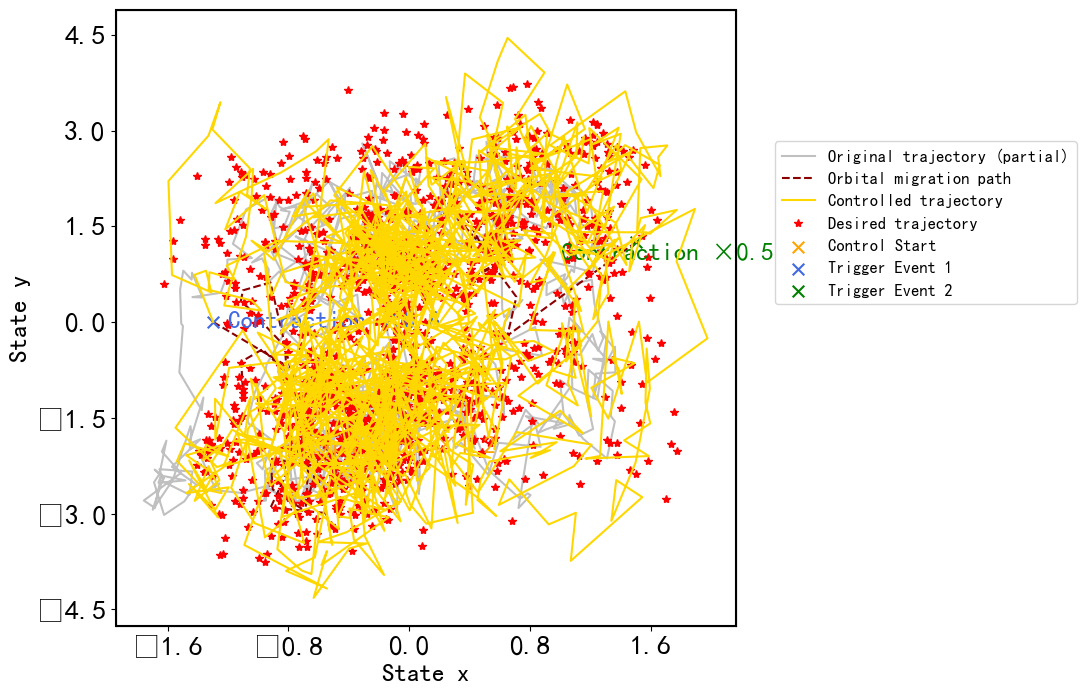

In [31]:
# plot attractor
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(original_data[0][:transient_end1],
        original_data[1][:transient_end1], 
        c = transient_color,zorder = -10,label='Original trajectory (partial)')

ax.plot(x[0][t1-1: transient_end1],
        x[1][t1-1: transient_end1],'--', 
        c = 'darkred',label='Orbital migration path')

ax.plot(x[0][transient_end1 : t2],
        x[1][transient_end1 : t2], 
        c = 'gold',zorder = 20,label='Controlled trajectory')

ax.plot(x[0][t2-1: transient_end2],
        x[1][t2-1: transient_end2],'--', 
        c = 'darkred')

ax.plot(x[0][transient_end2 : t3],
        x[1][transient_end2 : t3], 
        c = 'gold',zorder = 20)

ax.plot(x[0][t3-1: transient_end3],
        x[1][t3-1: transient_end3],'--', 
        c = 'darkred')

ax.plot(x[0][transient_end3 : data_length],
        x[1][transient_end3 : data_length], 
        c = 'gold',zorder = 20)

ax.plot(controlled_dict['Y_desired'][0][wait_time: data_length],
        controlled_dict['Y_desired'][1][wait_time: data_length],'*', 
        c = 'red',label='Desired trajectory')

# 标注 Control Start
ax.scatter(x[0][t1-1], x[1][t1-1], c='orange', zorder=10, marker='x', s=70, label='Control Start')
ax.text(x[0][t1-1] + 0.1, x[1][t1-1] + 0.1, "Expansion ×1.2", fontsize=fontsize, color='orange')

# 标注 Trigger Event 1
ax.scatter(x[0][t2-1], x[1][t2-1], c='royalblue', zorder=10, marker='x', s=70, label='Trigger Event 1')
ax.text(x[0][t2-1] + 0.1, x[1][t2-1] - 0.1, "Contraction ×0.8", fontsize=fontsize, color='royalblue')

# 标注 Trigger Event 2
ax.scatter(x[0][t3-1], x[1][t3-1], c='green', zorder=10, marker='x', s=70, label='Trigger Event 2')
ax.text(x[0][t3-1] - 0.5, x[1][t3-1] - 0.3, "Contraction ×0.5", fontsize=fontsize, color='green')
# setting x and y labels
ax.set_xlabel('State x',fontsize = fontsize)
ax.set_ylabel('State y',fontsize = fontsize)

# adjust ticks
ax.tick_params(axis='both', labelsize=ticksize)
ax.xaxis.set_major_locator(MaxNLocator(nbins=nbinsx_attractor))
ax.yaxis.set_major_locator(MaxNLocator(nbins=nbinsy_attractor))

# draw box around plot
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth(box_linewidth)  

# add legend
ax.legend(bbox_to_anchor=(1.05,0.8),fontsize=12)

# set title 
# ax.set_title('controlled attractor', fontsize=fontsize)


In [32]:
print('controlled point 1: ',(x[0][t1],x[1][t1]))
print('controlled point 2: ',(x[0][t2],x[1][t2]))
print('controlled point 3: ',(x[0][t3],x[1][t3]))

controlled point 1:  (np.float64(-0.9179287673503111), np.float64(-2.9013645763929796))
controlled point 2:  (np.float64(-0.7884454495513957), np.float64(-0.7163309760634058))
controlled point 3:  (np.float64(0.6513931735938464), np.float64(-0.20776519350727396))


# result

In [33]:
rmse = controlled_dict['controlled_rmse']
print('噪声强度和时间尺度为',sigma1,sigma2,epsilon)
print('RMSE: ',rmse)

噪声强度和时间尺度为 1 1 0.1
RMSE:  [0.38691701 0.14829854 0.52670399]


In [34]:
# # 定义存储文件名
# filename = "rmse_results.csv"

# # 假设 rmse 是一个 (3, 1) 维的 NumPy 数组或列表
# rmse = controlled_dict['controlled_rmse'].flatten()  # 确保 rmse 是 1D 数组

# # 创建 DataFrame
# data = pd.DataFrame([[sigma1, sigma2, epsilon, rmse[0], rmse[1], rmse[2]]],
#                     columns=["sigma1", "sigma2", "epsilon", "RMSE_total", "RMSE_x", "RMSE_y"])

# # 如果文件存在，则追加数据，否则创建新的文件
# if os.path.exists(filename):
#     data.to_csv(filename, mode='a', header=False, index=False)  # 追加数据，不写入表头
# else:
#     data.to_csv(filename, mode='w', header=True, index=False)   # 创建新文件，写入表头

# print("数据已存入", filename)

In [35]:
print('first control signal: ',(u[0][t1-1],u[1][t1-1]),(u[0][t2-1],u[1][t2-1]),(u[0][t3-1],u[1][t3-1]))
print('seconde control signal: ',(u[0][t1],u[1][t1]),(u[0][t2],u[1][t2]),(u[0][t3],u[1][t3]))
print('third control signal: ',(u[0][t1+1],u[1][t1+1]),(u[0][t2+1],u[1][t2+1]),(u[0][t3+1],u[1][t3+1]))

first control signal:  (np.float64(0.0), np.float64(0.0)) (np.float64(-6.504174548635155), np.float64(-4.920131833452538)) (np.float64(-19.071454549250763), np.float64(-26.65351964952629))
seconde control signal:  (np.float64(-9.243547801788615), np.float64(-117.82603477036358)) (np.float64(42.19543322315923), np.float64(-6.338507051656778)) (np.float64(-62.4904426343703), np.float64(-95.94232118370269))
third control signal:  (np.float64(18.937620423835966), np.float64(-22.76946457737889)) (np.float64(-26.65951304664321), np.float64(76.23050467919958)) (np.float64(15.128101760053939), np.float64(47.379710115209896))


In [36]:
# # plot desired perturbation
# fontsize = 20
# fig, ax = plt.subplots(1, 1, figsize=(8,4))   
# start_time = t1
# show_time =  data_length-start_time #maximum = data_length-start_time
# error_x = e[0]
# error_y = e[1]
# ax.plot(time_array[start_time : start_time+show_time], error_x[start_time : start_time+show_time], color = 'blue',zorder = 10,linewidth=2, label = r'error $e_x$')
# ax.plot(time_array[start_time : start_time+show_time], error_y[start_time : start_time+show_time], color = 'orange',linewidth=2, label = r'error $e_y$')
# ax.axvline(x=start_time,linestyle='dashed',c='black')
# ax.axvline(x=t2,linestyle='dashed',c='black')
# ax.axvline(x=t3,linestyle='dashed',c='black')
# # set x and y limits
# ax.set_xlim(start_time,start_time+show_time)
# # ax.set_xlim(start_time,start_time+10)
# # ax.set_xlim(t2,t2+10)
# # ax.set_xlim(t3,t3+10)
# # set x and y labels
# ax.set_xlabel('time step',fontsize=fontsize)
# ax.set_ylabel('Error per step',fontsize=fontsize)

# # set title
# ax.set_title(f'Error for controlled in first {show_time} steps',fontsize=fontsize)

# # adjust ticks
# ax.tick_params(axis='both', labelsize=fontsize)    
# plt.legend()
# # show plot
# plt.show()

# robustness analysis

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


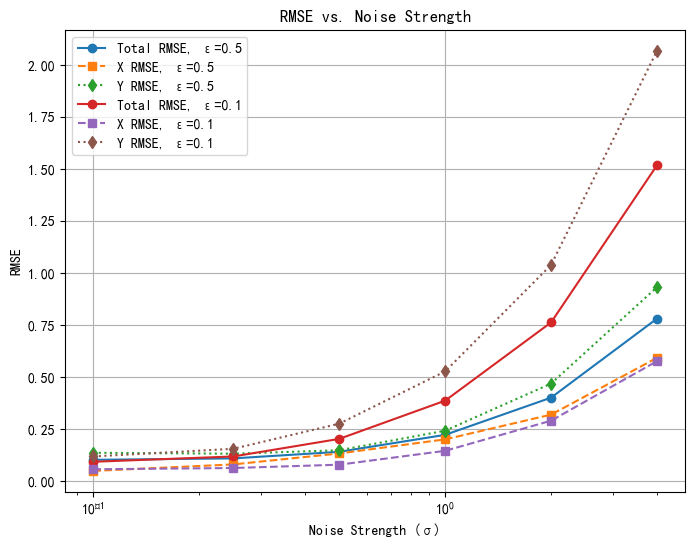

In [37]:
# 读取CSV数据
df = pd.read_csv("rmse_results.csv")

# 提取不同 epsilon 下的均值
epsilon_values = [0.5, 0.1]
sigma_values = [0.1, 0.25, 0.5, 1, 2, 4]

plt.figure(figsize=(8, 6))

for epsilon in epsilon_values:
    df_e = df[df["epsilon"] == epsilon].groupby("sigma1").mean()
    
    plt.plot(sigma_values, df_e["RMSE_total"], label=f"Total RMSE, ε={epsilon}", marker="o")
    plt.plot(sigma_values, df_e["RMSE_x"], label=f"X RMSE, ε={epsilon}", linestyle="--", marker="s")
    plt.plot(sigma_values, df_e["RMSE_y"], label=f"Y RMSE, ε={epsilon}", linestyle=":", marker="d")

plt.xscale("log")  # 如果数据变化剧烈，可用对数刻度
plt.xlabel("Noise Strength (σ)")
plt.ylabel("RMSE")
plt.title("RMSE vs. Noise Strength")
plt.legend()
plt.grid()
plt.show()


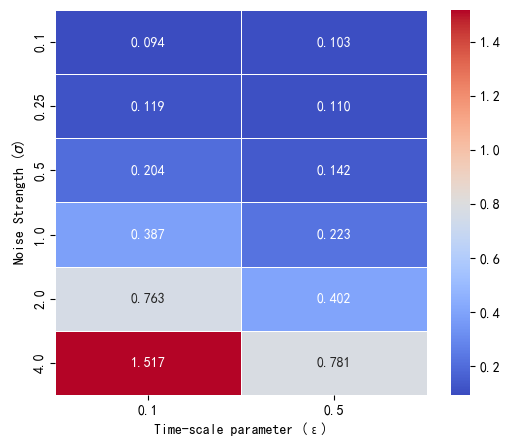

In [38]:
import seaborn as sns

# 计算平均 RMSE
df_pivot = df.groupby(["sigma1", "epsilon"]).mean().reset_index()
rmse_matrix = df_pivot.pivot(index="sigma1", columns="epsilon", values="RMSE_total")  # 选择 RMSE_total

plt.figure(figsize=(6, 5))
sns.heatmap(rmse_matrix, annot=True, fmt=".3f", cmap="coolwarm", linewidths=0.5)
plt.xlabel("Time-scale parameter (ε)")
plt.ylabel(r"Noise Strength ($\sigma$)")
# plt.title("Total RMSE Heatmap")
plt.show()